In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

/restricted/projectnb/czproj/A00/jlhan/packages/saturn/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
# Load the .h5ad file
frog = sc.read_h5ad('../data/frog.h5ad')
zebrafish = sc.read_h5ad('../data/zebrafish.h5ad')

/restricted/projectnb/czproj/A00/jlhan/packages/saturn/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
# Step 1: Get common genes
common_genes = frog.var_names.intersection(zebrafish.var_names)

# Step 2: Subset both datasets to only common genes
frog = frog[:, common_genes]
zebrafish = zebrafish[:, common_genes]

# Step 3: Add metadata to distinguish batches
frog.obs['batch'] = 'frog'
zebrafish.obs['batch'] = 'zebrafish'

# Step 4: Concatenate the datasets
adata = frog.concatenate(zebrafish, batch_key='batch', index_unique=None)

/scratch/352454.1.ood/ipykernel_1550755/826358746.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  frog.obs['batch'] = 'frog'
/restricted/projectnb/czproj/A00/jlhan/packages/saturn/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/restricted/projectnb/czproj/A00/jlhan/packages/saturn/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/scratch/352454.1.ood/ipykernel_1550755/826358746.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  zebrafish.obs['batch'] = 'zebrafish'
/scratch/352454.1.ood/ipykernel_1550755/826358746.py:13: FutureWarning: Use anndata.concat instead of AnnData.conca

In [4]:
# Step 5: Preprocessing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, batch_key='batch', n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

/restricted/projectnb/czproj/A00/jlhan/packages/saturn/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/restricted/projectnb/czproj/A00/jlhan/packages/saturn/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/restricted/projectnb/czproj/A00/jlhan/packages/saturn/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [5]:
# Step 6: Harmony integration
import harmonypy as hm
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'batch')
adata.obsm['X_pca_harmony'] = ho.Z_corr.T

2025-06-24 12:06:16,728 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-24 12:06:58,763 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-24 12:06:59,976 - harmonypy - INFO - Iteration 1 of 10
2025-06-24 12:08:15,560 - harmonypy - INFO - Iteration 2 of 10
2025-06-24 12:09:32,773 - harmonypy - INFO - Converged after 2 iterations


In [6]:
# Step 7: UMAP on Harmony output
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)

/restricted/projectnb/czproj/A00/jlhan/packages/saturn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


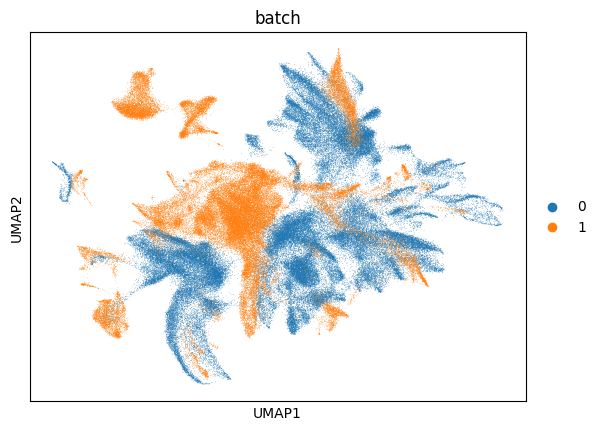

In [7]:
sc.pl.umap(adata, color='batch')

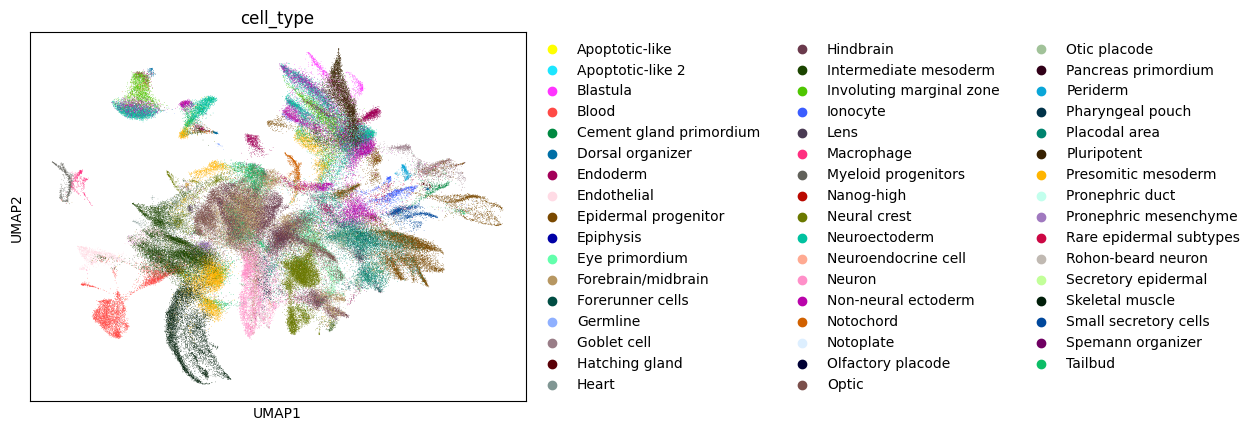

In [11]:
sc.pl.umap(adata, color='cell_type')

In [8]:
adata.obs

,library,clusters,dev_stage,parent_clusters,cell_type,n_genes,batch,n_counts,unique_cell_id,cell_names,library_id,ClusterID,ClusterName,TissueID,TissueName,TimeID,cluster
GACGATTGAT-AAAGTCGG,Library_1,blastula,Stage_8,Root,Blastula,5506,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGTTTACGT-GGGAGGTA,Library_1,blastula,Stage_8,Root,Blastula,5209,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CATCGCAG-CGAGATGT,Library_1,blastula,Stage_8,Root,Blastula,4880,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GATTGATCTA-TAAGACGG,Library_1,blastula,Stage_8,Root,Blastula,4930,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GATCGGTTTA-AAGATTGT,Library_1,blastula,Stage_8,Root,Blastula,4598,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993-28-6,NaN,NaN,NaN,NaN,Skeletal muscle,704,1,2525.0,DEW169_ATTTCCAT-CAGTCCCT,bcDANY,DEW169,135,24hpf-muscle - myl1,8,Mesoderm,24hpf,muscle - myl1
1994-28-6,NaN,NaN,NaN,NaN,Neuron,679,1,1548.0,DEW169_CTACGGGA-ATACCCAG,bcELQP,DEW169,157,24hpf-differentiating neurons - eomesa,1,Forebrain / Optic,24hpf,differentiating neurons - eomesa
2000-28-6,NaN,NaN,NaN,NaN,Forebrain/midbrain,1521,1,5054.0,DEW169_TGGAAAGC-CCGCAACT,bcIGIF,DEW169,138,24hpf-neural - diencephalon,1,Forebrain / Optic,24hpf,neural - diencephalon
2001-28-6,NaN,NaN,NaN,NaN,Intermediate mesoderm,1414,1,3270.0,DEW169_GAAAGACA-GTCCGTAC,bcFBRF,DEW169,178,24hpf-pharyngeal arch - ndnf,8,Mesoderm,24hpf,pharyngeal arch - ndnf


In [9]:
frog.obs

,library,clusters,dev_stage,parent_clusters,cell_type,n_genes,batch
GACGATTGAT-AAAGTCGG,Library_1,blastula,Stage_8,Root,Blastula,5506,frog
AGTTTACGT-GGGAGGTA,Library_1,blastula,Stage_8,Root,Blastula,5209,frog
CATCGCAG-CGAGATGT,Library_1,blastula,Stage_8,Root,Blastula,4880,frog
GATTGATCTA-TAAGACGG,Library_1,blastula,Stage_8,Root,Blastula,4930,frog
GATCGGTTTA-AAGATTGT,Library_1,blastula,Stage_8,Root,Blastula,4598,frog
...,...,...,...,...,...,...,...
TAAACCGA-CGTGGATA,Library_75,somite,Stage_22,somite,Skeletal muscle,721,frog
CGTCGAAT-TAGTGGAC,Library_75,presomitic mesoderm,Stage_22,presomitic mesoderm,Presomitic mesoderm,789,frog
TAGTCTCT-CGGCTTAC,Library_75,presomitic mesoderm,Stage_22,presomitic mesoderm,Presomitic mesoderm,677,frog
GTATACGT-ATATGCAT,Library_75,optic vesicle,Stage_22,eye primordium,Optic,603,frog


In [10]:
zebrafish.obs

,n_counts,unique_cell_id,cell_names,library_id,batch,ClusterID,ClusterName,TissueID,TissueName,TimeID,cluster,cell_type,n_genes
0-0-0,15111.0,DEW050_AGTCAATAC-TTGGATCG,bcGPGV,DEW050,zebrafish,1,04hpf-pluripotent,9,Pluripotent,4hpf,pluripotent,Pluripotent,5729
1-0-0,2337.0,DEW050_AAGAACGGG-GCGTTGCT,bcDSDI,DEW050,zebrafish,1,04hpf-pluripotent,9,Pluripotent,4hpf,pluripotent,Pluripotent,1506
2-0-0,2078.0,DEW050_GACCTACTAG-TTAGTCCG,bcENHV,DEW050,zebrafish,1,04hpf-pluripotent,9,Pluripotent,4hpf,pluripotent,Pluripotent,1393
3-0-0,1648.0,DEW050_GTTTGTTT-GGTCCCTT,bcAABE,DEW050,zebrafish,1,04hpf-pluripotent,9,Pluripotent,4hpf,pluripotent,Pluripotent,1164
4-0-0,1153.0,DEW050_TGATTGCACGC-TAACCATC,bcFTTU,DEW050,zebrafish,1,04hpf-pluripotent,9,Pluripotent,4hpf,pluripotent,Pluripotent,828
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993-28-6,2525.0,DEW169_ATTTCCAT-CAGTCCCT,bcDANY,DEW169,zebrafish,135,24hpf-muscle - myl1,8,Mesoderm,24hpf,muscle - myl1,Skeletal muscle,704
1994-28-6,1548.0,DEW169_CTACGGGA-ATACCCAG,bcELQP,DEW169,zebrafish,157,24hpf-differentiating neurons - eomesa,1,Forebrain / Optic,24hpf,differentiating neurons - eomesa,Neuron,679
2000-28-6,5054.0,DEW169_TGGAAAGC-CCGCAACT,bcIGIF,DEW169,zebrafish,138,24hpf-neural - diencephalon,1,Forebrain / Optic,24hpf,neural - diencephalon,Forebrain/midbrain,1521
2001-28-6,3270.0,DEW169_GAAAGACA-GTCCGTAC,bcFBRF,DEW169,zebrafish,178,24hpf-pharyngeal arch - ndnf,8,Mesoderm,24hpf,pharyngeal arch - ndnf,Intermediate mesoderm,1414
